## Installing Firebase SDK
Our data comes from firebase so we install the firebase SDK to access it.

In [7]:
!pip install firebase-admin
!pip install keras

# Inputs and Features

As an input, our model will receive a json file with all the emails labeled and will pass as a dataframe. The features in our dataset are the language of the email, the type, the majors that applies to the email & the audience that applies.

The labels in our datasets are:

**Internship or Job Application** - Applies to internships opportunities from companies & job applications from the university.

**Scholarships & Fellowship** - Applies scholarships opportunity for all the students & Fellowships from a variety of organizations.

**Volunteer** - Volunteering experience for all the students.

**Sports & Fitness** - A variety of opportunities to be part of a sport team of the university of be part of a class to do a variety of exercises.

**Workshops** - Opportunities of a variety of workshops or 

**Class** - Any announcement regarding to a class of the university.

**Competition** - Opportunities of competitions for the students.

**Conference** - A variety of talks, conferences from a faculty member of the university or from a company.

**Social Events** - An event for everybody to join. 

**Sale** - Any sale made within the university.

**Research** - Any research opportunity for the students or announcement from the researches within the university.

**Health & Security** - Announcements to do exercises like zumba & dancing. 

**Students Associations** - Any announcement regarding to the student associations from the university.

**University Announcements** - Any announcement from the university. 

**Other** - Any other email that can not be categorized from the previous labels.

**Spanish**

**English**

**Engineering**

**Arts & Science**

**Business**

**Agriculture**

**All Majors**

**Undergradute Students**

**Graduate Students**

**Faculty**

**All Students**

**Everyone**

## Using Keras to build neural network
Reference: https://www.tensorflow.org/guide/keras#train_and_evaluate

Reference 2: https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb

In [29]:
from keras.preprocessing import text, sequence
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras import regularizers
from keras import metrics
import pandas as pd
import numpy as np
import math
import re
import json
from firebase_admin import db, credentials
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras import optimizers
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15
pd.options.mode.chained_assignment = None  # default='warn'

seed = 7
np.random.seed(seed)

## Firebase Admin SDK credentials
Our service account file is in our google drive so we import it from google drive by mounting the google drive into the colab.

In [21]:
import firebase_admin
if (not len(firebase_admin._apps)):
    cred = credentials.Certificate('./easy-cartero-firebase-adminsdk-1sp67-ffb2ac83bf.json') 
    default_app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://easy-cartero.firebaseio.com/'})

In [22]:
# Get a database reference to our posts
ref = db.reference();
ref = ref.child('Production/labeled')
data = ref.get()

#convert dictionary into array of items
emails = json.dumps(list(data.values()))
df = pd.read_json(emails)
df.describe()
#We have the first 162 emails with NaN so we replace with default value
for index in range(0,163):
  df['audience'][index] = ['Everyone']

In [23]:
#Cleans up the body of the email by removing punctuation
def sanitize_features(df):
  """
  This function will replace urls with ' LINK '. It
  also makes label column to collect all labels into 
  one column.
  """
  print('Cleaning Data...')
  df['labels'] = [[] for _ in range(len(df))]
  #df['encoded_labels'] = [[] for _ in range(len(df))]
  for index in range(0, df['body'].size):
    df['body'][index] = re.sub(r'^https?:\/\/.*[\r\n]*', ' LINK ', str(df['body'][index]), flags=re.MULTILINE).lower()
    labels = []
    labels.extend(df['audience'][index])
    labels.extend(df['emailType'][index])
    labels.extend(df['majors'][index])
    labels.append(df['language'][index])
    df['labels'][index] = labels
  print('Finished Clearning!')

In [24]:
##clean data and remove unnecessary columns
sanitize_features(df)
df.drop(columns=['audience','author', 'date', 'emailType', 'key', 'language', 'majors', 'subject'])

Cleaning Data...
Finished Clearning!


,body,labels
0,"¡saludos, colegiales!\r\r\n\r\r\n\r\r\nel depa...","[Everyone, University Announcement, Arts & Sci..."
1,"¡saludos, colegiales!\r\r\n\r\r\n¿te has pregu...","[Everyone, Class, Arts & Sciences, Spanish]"
2,el comité de búsqueda y consulta del senado ac...,"[Everyone, Competition, University Announcemen..."
3,"¡saludos, colegiales y comunidad en general!\r...","[Everyone, Sports & Fitness, Class, All Majors..."
4,el comite de búsqueda y consulta para el nombr...,"[Everyone, Competition, University Announcemen..."
5,"estimada comunidad universitaria,\r\r\n\r\r\nl...","[Everyone, Competition, Business, Spanish]"
6,"¡¡saludos colegiales!!\r\r\n\r\r\nven, anímate...","[Everyone, Sports & Fitness, Class, All Majors..."
...,...,...
1394,faltan 32 días para el evento por la vida y el...,"[Everyone, Volunteer, University Announcement,..."
1395,"saludos colegiales,\r\r\n\r\r\ncover letters a...","[Undergraduate Student, Graduate Student, Work..."


In [25]:
possible_labels = ['Internship or Job Application','Scholarships & Fellowship','Volunteer','Sports & Fitness','Workshop','Class',
                    'Competition','Conference','Social Events','Sale','Research','Health & Security','Student Associations',
                    'University Announcement', 'Other','Spanish','English','Engineering','Arts & Sciences','Business','Agriculture',
                    'All Majors','Undergraduate Student','Graduate Student','Faculty','All Students','Everyone']

## shuffle data
df.reindex(np.random.permutation(df.index))
#define training data size
train_data_ratio = 1.0
training_size = int(len(df) * train_data_ratio)

#split data into training and validation data
training_emails = df['body'][:training_size]
training_labels = df['labels'][:training_size]

validation_emails = df['body'][:training_size]
validation_labels = df['labels'][:training_size]

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit_transform(df['body']).todense()

vocabulary_size = len(vectorizer.vocabulary_) 
tokenize = text.Tokenizer(num_words=vocabulary_size, char_level=False, lower=False, split=' ')

tokenize.fit_on_texts(training_emails) # only fit on train
tokenized_emails_train = tokenize.texts_to_matrix(training_emails)
tokenized_emails_validation = tokenize.texts_to_matrix(validation_emails)

# Use sklearn utility to convert label strings to numbered index
encoder = MultiLabelBinarizer(classes= possible_labels)
encoder.fit(df['labels'])
encoded_training = encoder.transform(training_labels)
encoded_validation = encoder.transform(validation_labels)
num_classes = len(possible_labels)

print('tokenized_emails_train shape:', tokenized_emails_train.shape)
print('tokenized_emails_validation shape:', validation_emails.shape)
print('encoded_training shape:', encoded_training.shape)
print('encoded_validation shape:', encoded_validation.shape)

tokenized_emails_train shape: (1401, 13395)
tokenized_emails_validation shape: (1401,)
encoded_training shape: (1401, 27)
encoded_validation shape: (1401, 27)


In [32]:

def build_model(l1_reg, l2_reg, learning_rate, vocabulary_size, num_classes):
  model = Sequential([
    Dense(2048, input_shape = (vocabulary_size,), activation = 'relu', kernel_regularizer=regularizers.l2(l2_reg), activity_regularizer=regularizers.l1(l1_reg)),
    Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(l2_reg), activity_regularizer=regularizers.l1(l1_reg)),
    Dense(num_classes, activation='sigmoid')
  ])
  model.compile(optimizer = optimizers.Adam(lr = learning_rate),
                loss ='binary_crossentropy',
                metrics = [metrics.binary_accuracy])
  return model

# Training Our Model

In [33]:
def train_model(model, tokenized_emails_train, encoded_label_training, tokenized_emails_validation, encoded__label_validation, batch_size = 150, steps = 100, epochs = 5, verbose = 1, validation_split = 0.5):
  train = model.fit(tokenized_emails_train, encoded_training,
                    batch_size= batch_size, 
                    epochs= epochs, 
                    verbose= verbose,
                    validation_split= validation_split)
  evaluation = model.evaluate(tokenized_emails_validation,
                            encoded__label_validation, 
                            batch_size= batch_size, 
                            verbose= verbose)
  print('Test score:', evaluation[0])
  print('Test accuracy:', evaluation[1])
  print (evaluation)
  return train

batch_size = 100
steps = 75
epochs = 5
verbose = 1
validation_split = 0.4
L1_regularization = 0.0000025
L2_regularization = 0.00000025
LEARNING_RATE = 0.001
Positive_Label_Threshold = 0.5

model = build_model(
  l1_reg = L1_regularization,
  l2_reg = L2_regularization, 
  learning_rate = LEARNING_RATE,
  vocabulary_size = len(vectorizer.vocabulary_),
  num_classes = num_classes
)

history = train_model(
  model = model,
  tokenized_emails_train = tokenized_emails_train,
  encoded_label_training = encoded_training,
  tokenized_emails_validation = tokenized_emails_validation,
  encoded__label_validation = encoded_validation,
  batch_size = batch_size,
  steps = steps,
  epochs = epochs,
  verbose = verbose,
  validation_split = validation_split
)

Train on 840 samples, validate on 561 samples
Epoch 1/5
840/840 [==============================] - 6s 8ms/step - loss: 0.5177 - binary_accuracy: 0.8018 - val_loss: 0.4240 - val_binary_accuracy: 0.8774
Epoch 2/5
840/840 [==============================] - 1s 1ms/step - loss: 0.3542 - binary_accuracy: 0.9011 - val_loss: 0.3717 - val_binary_accuracy: 0.8804
Epoch 3/5
840/840 [==============================] - 1s 1ms/step - loss: 0.2755 - binary_accuracy: 0.9246 - val_loss: 0.3747 - val_binary_accuracy: 0.8832
Epoch 4/5
840/840 [==============================] - 1s 1ms/step - loss: 0.2218 - binary_accuracy: 0.9501 - val_loss: 0.3507 - val_binary_accuracy: 0.8874
Epoch 5/5
1401/1401 [==============================] - 1s 384us/step
Test score: 0.24768607657692587
Test accuracy: 0.9368176288812353
[0.24768607657692587, 0.9368176288812353]


Reference: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
 
def plot_history(history):
    keys = history.history.keys()
    # eprint(keys)
    for key in filter(lambda k:"val_" not in k,  keys):   
        plt.plot(history.history[key])
        plt.plot(history.history['val_'+key ])
        plt.title(key)
        plt.ylabel('key')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

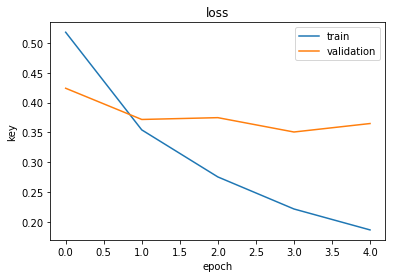

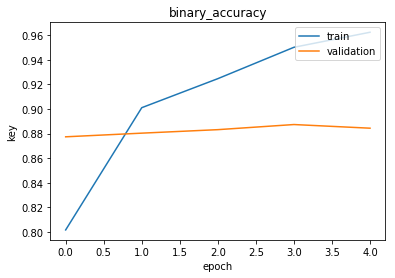

In [35]:
plot_history(history)

## Metrics & testing

In [ ]:
def make_roc_curve(predictions, targets, possible_labels):
  """ Plots an ROC curve for the provided predictions and targets.

  Args:
    predictions: the probability that the example has label 1.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """
  for i in range(len(possible_labels)):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      [row[i] for row in targets], [row[i] for row in predictions])
    plt.subplot(5,6,i+1, title= possible_labels[i])
    plt.plot(false_positive_rate, true_positive_rate)
    plt.ylabel("true positive rate")
    ?plt.xlabel("false positive rate")
  plt.show()
  

In [ ]:
from sklearn import metrics
predictions = model.predict(tokenized_emails_train)
fig = plt.gcf()
fig.set_size_inches(20, 20, forward=True)
make_roc_curve(predictions, encoded_training, possible_labels)

In [ ]:
text = "The Industrial Engineering Honor Society Alpha Pi Mu invites you to collaborate in our School Supplies Drive Supplies will be donated to students with special education needs from Elpidio H Rivera School in Mayag\xFCez We will be collecting items until December 3rd in II 101 You can also contact our Community Service Director Cristina Qui\xF1ones at\xA0LINK for the delivery of items and more information The items being collected are pencils crayons construction paper copy paper erasers rulers scissors glue markers disinfecting wipes baby wipes paper towels You can also donate money for the purchase of school supplies through ATH M\xF3vil to the number 787 410 8314 Please send it with the message supply so we know the money is for cooperating with the cause Giving is not just about making a donation It is about making a difference Kathy Calvin Thank you" #@param {type:"string"}

In [ ]:
def extract_labels_from_prediction(possible_labels, prediction, threshold):
  labels = []
  for index in range(0, len(possible_labels)):
    if(prediction[index] >= threshold):
      labels.append(possible_labels[index])
  return labels

In [ ]:
for i in range(0, len(predictions)):
  predicted_label = extract_labels_from_prediction(encoder.classes_, predictions[i], Positive_Label_Threshold)
  actual_labels = extract_labels_from_prediction(encoder.classes_, encoded_training[i], Positive_Label_Threshold)
  print(training_emails[i])
  print("Predicted labels: " + str(predicted_label) + "\n")
  print("Actual labels: " + str(actual_labels) + "\n") 